In [2]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

In [3]:
import sys
TRAIN = True
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [4]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [5]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [6]:

if not IN_COLAB:
  import analyser.hyperparams  
  _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
  work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)
  
  if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

  analyser.hyperparams.work_dir = work_dir
else:
  import analyser.hyperparams
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
  analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v1.22.0
USING WORKDIR: [/Users/artem/work/nemo/goil/nlp_tools/work]
 set ENV GPN_WORK_DIR to override
work_dir= /Users/artem/work/nemo/goil/work


/Users/artem/work/nemo/goil/nlp_tools/analyser/hyperparams.py:14: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [7]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 
import os
import random
import math
import json
import warnings

from os import path

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, seq_labels_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


1.15.2


Using TensorFlow backend.


loading word cases stats model from: /Users/artem/work/nemo/goil/nlp_tools/analyser/vocab/word_cases_stats.pickle
HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


# Prepare trainset


In [8]:
umtm = UberModelTrainsetManager ( analyser.hyperparams.work_dir)

if not IN_COLAB:
  umtm.import_recent_contracts()
  umtm.calculate_samples_weights()
  umtm.validate_trainset()

I0630 18:26:16.368343 4748930496 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 609
I0630 18:26:16.528959 4748930496 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 609
I0630 18:26:16.532046 4748930496 retrain_contract_uber_model.py:177] latest export_date: [2020-06-28 23:02:42.463000]
I0630 18:26:16.533171 4748930496 retrain_contract_uber_model.py:179] obtaining DB connection...
/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_HOST environment variable! defaulting to localhost
  warnings.warn(msg)
/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)
I0630 18:26:16.550621 4748930496 retrain_contract_uber_model.py:182] obtaining DB c

In [9]:
umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
umtm.stats

/Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,export_date,subject,org-1-alias,org-2-alias,checksum,version,analyze_date,value,value_log1p,value_span,subject confidence,user_correction_date,valid,subject_weight,sample_weight,error,errors
_id,,,,,,,,,,,,,,,,,
5eea279dc28b75807f3dacce,2020-06-26 21:19:39.652608,Loans,Заемщик,Займодавец,a2fd74d33e546dc0fde7ae1d50eb3cae,1.20.0,2020-06-18 20:26:19.609,6.040500e+10,24.824338,148.0,0.997801,2020-06-17 15:44:57.491,True,6.798760,4.308574,NaN,1
5eea279dc28b75807f3daccb,2020-06-26 21:19:39.455999,Loans,Займодавец,Заемщик,839bd7f3a1a443ffdf00c200788df8b3,1.20.0,2020-06-18 20:25:14.243,2.215000e+09,21.518518,159.0,0.973850,2020-06-17 15:45:57.928,True,5.893380,3.734808,NaN,1
5eea27b1c28b75807f3daec7,2020-06-26 21:20:14.792316,GeneralContract,Заказчик,Подрядчик,571145b01a3a2e2ac7f486d3f73a1b19,1.20.0,2020-06-19 18:46:02.512,1.789183e+09,21.305025,4826.0,0.388674,2020-06-19 10:23:11.225,True,4.244106,3.697753,NaN,0
5dfa6a938d25a1ac83160bf1,2020-06-26 21:17:55.126244,Service,Заказчик,Исполнитель,e10d3bc6db3c286eddbbbc9107850830,1.11.2,2020-06-12 21:20:30.568,1.770000e+09,21.294245,9482.0,0.984551,2020-06-06 11:44:17.759,True,2.479440,3.695882,NaN,1
5eea27a9c28b75807f3dade2,2020-06-26 21:19:49.010035,GeneralContract,ЗАКАЗЧИК,ПОДРЯДЧИК,10c564092c2014bdcb294c13d4e1d670,1.20.0,2020-06-18 23:12:32.528,1.077877e+09,20.798260,2184.0,0.886859,2020-06-17 20:19:02.229,True,4.143154,3.609798,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5edbc662da3678279fbcaee3,2020-06-26 21:18:35.961911,Service,Владелец Лицензии,Оператор,e4a73074aa926fad45a8d2d4eec06619,1.11.5,2020-06-16 11:23:18.643,NaN,NaN,NaN,0.999367,NaT,True,0.011636,0.017345,NaN,0
5edbc65fda3678279fbcae91,2020-06-26 21:18:30.856139,Service,Владелец Лицензии,Оператор,de8d0defd01d62a35e971d556f18037d,1.11.5,2020-06-16 11:19:38.025,NaN,NaN,NaN,0.998887,NaT,True,0.011631,0.017337,NaN,0
5edbc65dda3678279fbcae68,2020-06-26 21:18:28.936219,Service,Заказчик,,e6050d7bfaa96e7a8b283c36c4490687,1.11.5,2020-06-16 11:18:03.345,NaN,NaN,NaN,0.999537,NaT,True,0.011638,0.017348,NaN,0


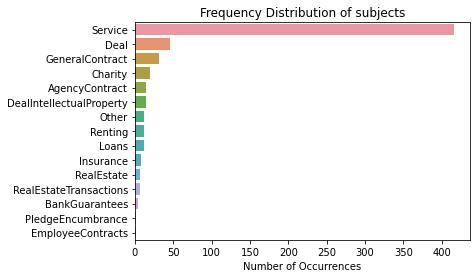


min 2
max 416
total 608


In [10]:
%matplotlib inline

subj_count = umtm.stats['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [11]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = umtm.stats['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(umtm.stats, 'subject')
class_weights

classes: ['Loans', 'GeneralContract', 'Service', 'BankGuarantees', 'Insurance', 'AgencyContract', 'RealEstateTransactions', 'Renting', 'Charity', 'PledgeEncumbrance', 'Deal', 'RealEstate', 'DealIntellectualProperty', 'Other', 'EmployeeContracts']


Service                     0.362664
Deal                        0.568285
GeneralContract             0.625762
Charity                     0.718662
AgencyContract              0.789148
DealIntellectualProperty    0.789148
Other                       0.853031
Renting                     0.853031
Loans                       0.853031
Insurance                   0.995794
RealEstate                  1.124400
RealEstateTransactions      1.124400
BankGuarantees              1.359470
PledgeEncumbrance           1.991587
EmployeeContracts           1.991587
Name: subject, dtype: float64

I0630 18:26:37.514477 4748930496 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 609
I0630 18:26:37.755407 4748930496 retrain_contract_uber_model.py:283] docs in meta: 609
I0630 18:26:37.764314 4748930496 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 609


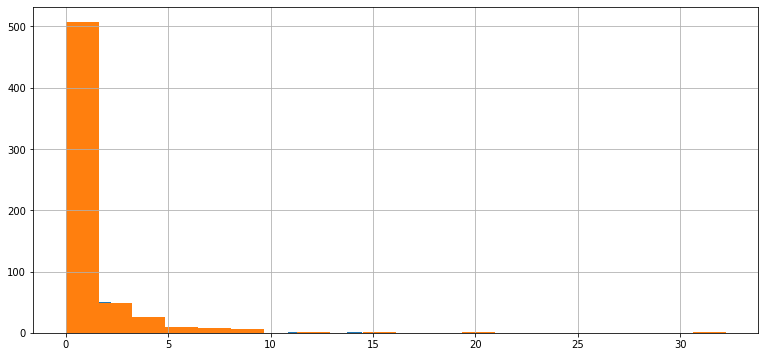

In [12]:
from trainsets.trainset_tools import get_feature_log_weights

def calculate_samples_weights(self):
  # TODO: sync with github!
  self.stats: DataFrame = self.load_contract_trainset_meta()
  subject_weights = get_feature_log_weights(self.stats, 'subject')
  
  value_median = self.stats.value_log1p.median()

  for i, row in self.stats.iterrows():
    subj_name = row['subject']

    tagging_weight = 1.0
    if not pd.isna(row['user_correction_date']):  # MORE weight for user-corrected datapoints
      tagging_weight = 10.0  # TODO: must be estimated anyhow smartly

    value_weight = value_median
    if not pd.isna(row['value_log1p']):
      # вес пропорционален логорифму цены контракта,
      # чтобы было меньше ошибок в контрактах на большие суммы)
      value_weight = row['value_log1p']

    tagging_weight *= value_weight
    subject_weight = tagging_weight * class_weights[subj_name]

    if 'errors' in row:
      ## giving more weight to incorrectly analyzed docs
      subject_weight = subject_weight *(1.0 + row['errors'])
      tagging_weight = subject_weight *(1.0 + row['errors'])

    self.stats.at[i, 'subject_weight'] = subject_weight
    self.stats.at[i, 'sample_weight']  = tagging_weight

  # NORMALIZE weights, so the sum == Number of samples
  self.stats.sample_weight /= self.stats.sample_weight.mean()
  self.stats.subject_weight /= self.stats.subject_weight.mean()

  self._save_stats()

calculate_samples_weights(umtm)

plt.figure(figsize=(13, 6))

umtm.stats['subject_weight'].hist(bins=20)
umtm.stats['sample_weight'].hist(bins=20)

plt.xscale('linear') # log?
plt.show()

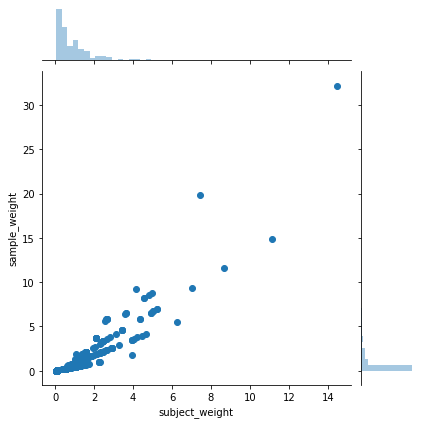

In [13]:
sns.jointplot(x="subject_weight", y="sample_weight", data=umtm.stats )
plt.show()


### look into trainset

In [14]:
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = umtm.stats.index[0]
print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
dp = umtm.make_xyw(SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
 

SAMPLE_DOC_ID 5eea279dc28b75807f3dacce


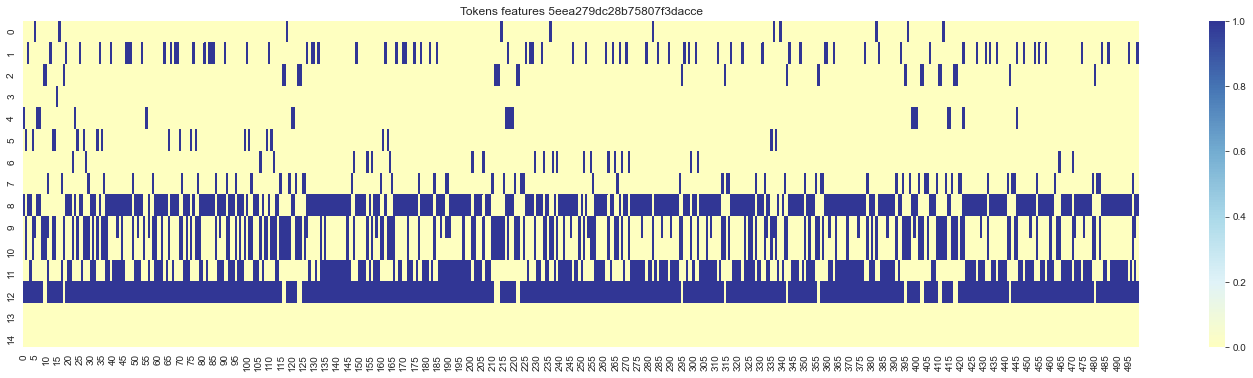

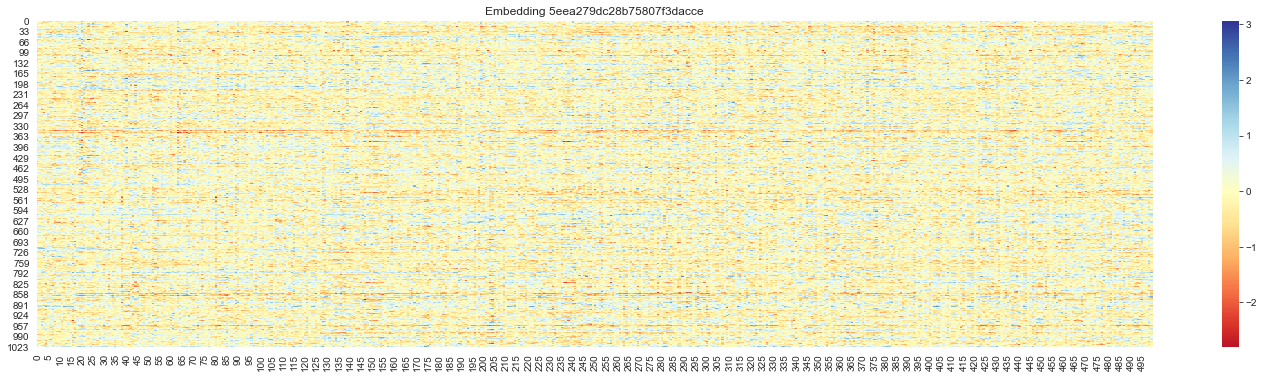

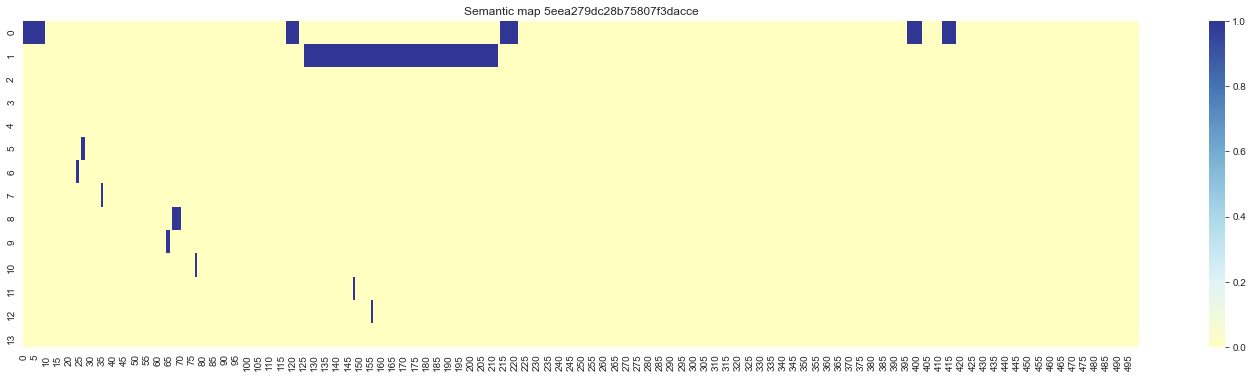

In [15]:
%matplotlib inline

plot_embedding(tok_f[:500], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:500], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:500], title=f'Semantic map {SAMPLE_DOC_ID}')

## Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq

In [16]:
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):

  np.random.seed(42)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len =  random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = self.make_xyw(doc_id)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      subject_weight_K=1.0
      if augment_samples:
        start_from = 0
        
        row = self.stats.loc[doc_id]
        if random.randint(1, 2) == 1:  # 50% of samples
          segment_center = random.randint(0, len(emb)-1) ##select random token as a center
          if not pd.isna(row['value_span']) and random.random()<0.7:        
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1 #lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Return a tuple of (input, output, weights) to feed the network
    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
            [np.array(batch_output_sm), np.array(batch_output_subj)],
            [np.array(weights), np.array(weights_subj)])

train_indices[0]: 5eea27abc28b75807f3dae09
test_indices[0]: 5eea27b3c28b75807f3daf23
X: 2 X[0]= (24, 1184, 1024) X[1]= (24, 1184, 15)
Y: 2 Y[0]= (24, 1184, 14) Y[1]= (24, 43)


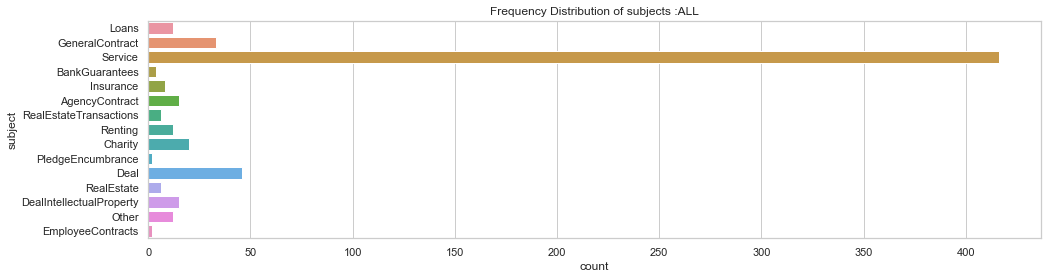

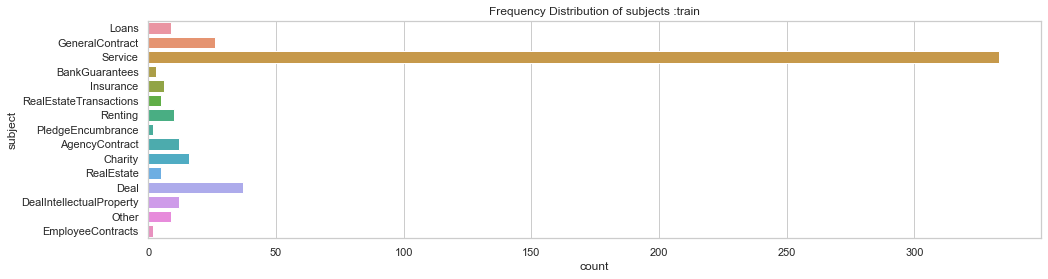

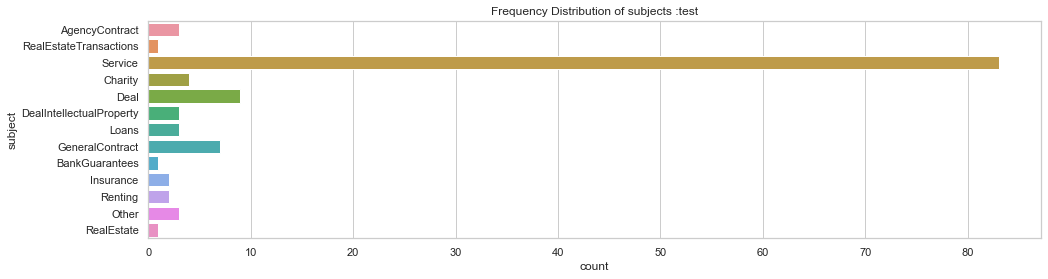

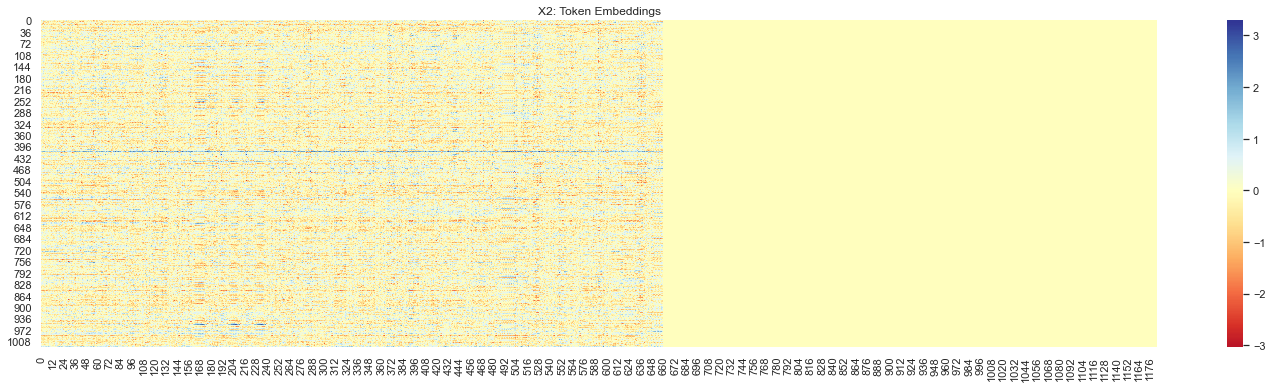

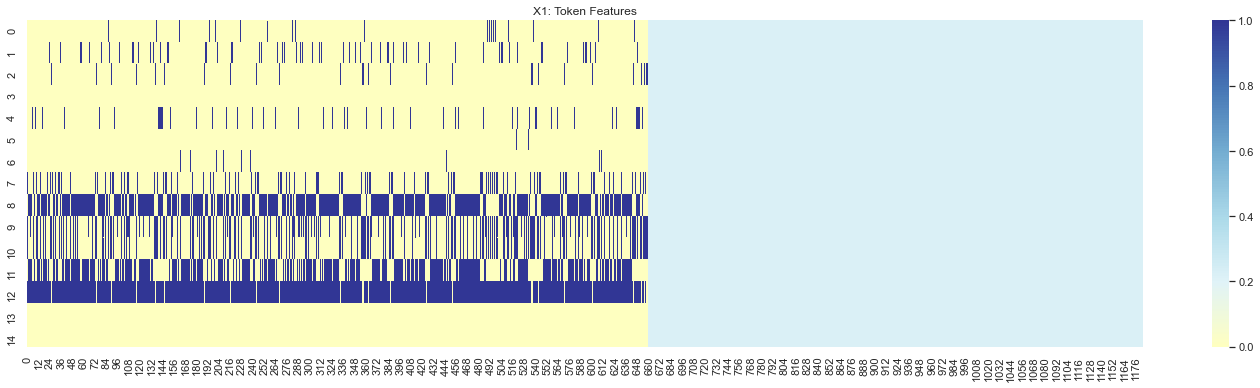

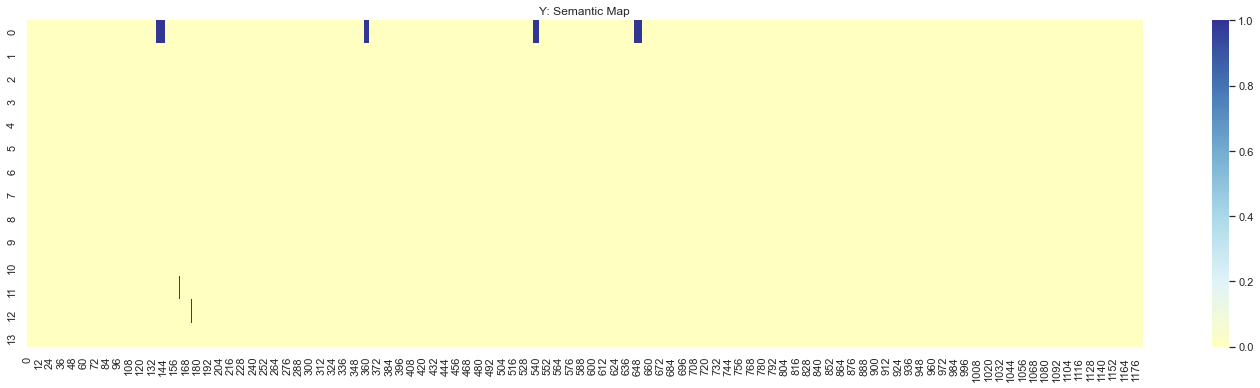

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [17]:
EPOCHS = 50
BATCH_SIZE = 24
EMB =  1024
 
_SELFTEST = True


_train, _test = train_test_split(umtm.stats, test_size=0.2, stratify=umtm.stats[['subject']])
train_indices = list(_train.index)
test_indices = list(_test.index)


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(umtm.stats, 'ALL')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(train_indices)], 'train')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
  print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
  print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

  plot_embedding(x[0][0], 'X2: Token Embeddings')
  plot_embedding(x[1][0], 'X1: Token Features')
  plot_embedding(y[0][0], 'Y: Semantic Map')
  
  print(y[0][1])

  del x
  del w
  del y
  del train_gen

In [18]:

ctx = KerasTrainingContext(umtm.work_dir, session_index=21)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


batch_size:	24
train_samples:	1948
test_samples:	122
steps_per_epoch:	81
validation_steps:	40


In [19]:



def init_model(model_fn) -> (Model, KerasTrainingContext):
  model_name = model_fn.__name__
  model = model_fn(name=model_name, ctx=ctx, trained=True)
  model.name = model_name

  weights_file_old = os.path.join(models_path, model_name + ".weights")
  weights_file_new = os.path.join(umtm.work_dir, model_name + ".weights")

  try:
    model.load_weights(weights_file_new, by_name=True )
    logger.info(f'weights loaded: {weights_file_new}')

  except:
    msg = f'cannot load  {model_name} from  {weights_file_new}'
    warnings.warn(msg)
    logger.warning(msg)
    model.load_weights(weights_file_old, by_name=True )
    logger.info(f'weights loaded: {weights_file_old}')

  # freeze bottom 6 layers, including 'embedding_reduced' #TODO: this must be model-specific parameter
  for l in model.layers[0:6]:
    l.trainable = False

  model.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  model.summary()

  return model




# Models 🦖

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [20]:
umodel = init_model(uber_detection_model_005_1_1)

W0630 18:27:05.110799 4748930496 deprecation.py:506] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0630 18:27:05.908055 4748930496 module_wrapper.py:139] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

INFO - 2020-06-30 18:27:08,454 - retrain_ipynb - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
INFO - 2020-06-30 18:27:08,454 - retrain_ipynb - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
I0630 18:27:08.454053 4748930496 <ipython-input-19-

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

In [21]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 25
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

In [22]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  umodel.summary()

  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

# Evaluate models

In [23]:
umodel = ctx.init_model(uber_detection_model_005_1_1, trained=True)

weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights


### training history

In [24]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.work_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid()
        plt.title(f'{metric}')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{m} {title}')
        plt.grid()
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        plt.savefig(img_path, bbox_inches='tight')
        plt.grid()
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')

## Contract subj Confusion matrices

In [25]:
from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId


  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)


def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame) -> SemanticTag or None:
  att = tagging[tagname].values
  slices = find_top_spans(att, threshold=0.3, limit=1)
  if len(slices) > 0:
    span = slices[0].start, slices[0].stop
    value = textmap.text_range(span)
    tag = SemanticTag(tagname, value, span)
    tag.confidence = att[slices[0]].mean()
    return tag
  return None


agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]
tagnames = solo_tags + agent_tags


def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = fetch_tag_value(key, _map, tagsmap)
    results[key] = t
    # print(t)

  ca = ContractAgent()
  ca.name = results['org-1-name']
  ca.type = results['org-1-type']
  ca.alias = results['org-1-alias']
  normalize_contract_agent(ca)

  ca = ContractAgent()
  ca.name = results['org-2-name']
  ca.type = results['org-2-type']
  ca.alias = results['org-2-alias']
  normalize_contract_agent(ca)

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]


def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for _id in indices:
    x, y, _ = umtm.make_xyw(_id)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags


subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
ev, tags = make_subj_predictions(umodel, subset.index)
tags.to_csv('all_contracts_predicstions.csv')

W0630 18:27:11.969280 4748930496 module_wrapper.py:139] From /Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

I0630 18:27:13.376647 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5deba9034ddc27bcf92dd383
/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
I0630 18:27:13.574864 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded4e284ddc27bcf92dd6ce
I0630 18:27:14.167590 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded4e294ddc27bcf92dd6d4
I0630 18:27:14.369761 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded4e294ddc27bcf92dd6d5
I0630 18:27:14.620352 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5df620b9200a3f4d0fad777c
I0630 18:27:15.104619 4748930496 <ipython-input-25-401

I0630 18:28:05.022454 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc59cda3678279fbcac7d
I0630 18:28:05.333016 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc59cda3678279fbcac89
I0630 18:28:05.863775 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc59dda3678279fbcac8b
I0630 18:28:06.330119 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc59eda3678279fbcac9f
I0630 18:28:06.572122 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc59eda3678279fbcaca1
I0630 18:28:06.795565 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc59eda3678279fbcaca2
I0630 18:28:07.298839 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc59eda3678279fbcacae
I0630 18:28:07.649271 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc59fda3678279fbcaccd
I0630 18:28:08.028772 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc5aada3678279fbcad32
I0630 18:28:08.814532 4748930496 <ipython-input-25-4012d138627b>:17] fetc

I0630 18:29:03.163045 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc66cda3678279fbcafea
I0630 18:29:04.333079 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc66cda3678279fbcaff3
I0630 18:29:05.395192 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc66dda3678279fbcaffd
I0630 18:29:06.441622 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc66dda3678279fbcaffe
I0630 18:29:07.320869 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc66dda3678279fbcb012
I0630 18:29:08.575719 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc66dda3678279fbcb01c
I0630 18:29:09.647994 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc66eda3678279fbcb02e
I0630 18:29:12.099730 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5edbc66eda3678279fbcb03e
I0630 18:29:12.957726 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee372a72281f29204c5250d
I0630 18:29:13.566229 4748930496 <ipython-input-25-4012d138627b>:17] fetc

I0630 18:30:06.535937 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07024ddc27bcf92dd4c0
I0630 18:30:07.296738 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07024ddc27bcf92dd4c3
I0630 18:30:08.030585 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07184ddc27bcf92dd4e9
I0630 18:30:08.368617 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07184ddc27bcf92dd4ec
I0630 18:30:08.600286 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07184ddc27bcf92dd4f3
I0630 18:30:09.031953 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07184ddc27bcf92dd509
I0630 18:30:09.486095 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07184ddc27bcf92dd50e
I0630 18:30:09.917344 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07184ddc27bcf92dd510
I0630 18:30:10.236029 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ded07184ddc27bcf92dd563
I0630 18:30:10.890841 4748930496 <ipython-input-25-4012d138627b>:17] fetc

I0630 18:30:52.218944 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27a3c28b75807f3dadab
I0630 18:30:52.850958 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27a8c28b75807f3dadd7
I0630 18:30:53.373005 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27a9c28b75807f3dadd8
I0630 18:30:54.008429 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27a9c28b75807f3dadd9
I0630 18:30:55.020900 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27aac28b75807f3dae04
I0630 18:30:56.503767 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27abc28b75807f3dae08
I0630 18:30:57.441202 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27abc28b75807f3dae09
I0630 18:30:58.282937 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27abc28b75807f3dae0a
I0630 18:30:58.872778 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5eea27abc28b75807f3dae10
I0630 18:30:59.457052 4748930496 <ipython-input-25-4012d138627b>:17] fetc

I0630 18:32:13.855926 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee8c456c28b75807f3dabe4
I0630 18:32:14.768326 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee8c456c28b75807f3dabe5
I0630 18:32:16.327744 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee832322281f29204c52c28
I0630 18:32:18.039854 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee832322281f29204c52c29
I0630 18:32:19.727169 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee832322281f29204c52c2a
I0630 18:32:21.486833 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee832322281f29204c52c2b
I0630 18:32:23.144164 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee832322281f29204c52c2c
I0630 18:32:25.538672 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee832322281f29204c52c2d
I0630 18:32:27.771535 4748930496 <ipython-input-25-4012d138627b>:17] fetching 5ee832322281f29204c52c2e
I0630 18:32:28.628785 4748930496 <ipython-input-25-4012d138627b>:17] fetc

In [29]:
errors_report = ev [ ev.wrong == True].sort_values('expected_subj')
print(len(errors_report), 'wrong subjects of', len(tags))
errors_report[ ['predicted_subj', 'subject', 'org-1-alias','org-2-alias'] ]

24 wrong subjects of 419


,predicted_subj,subject,org-1-alias,org-2-alias
_id,,,,
5edbc66ada3678279fbcafb5,GeneralContract,AgencyContract,Принципал,Агент
5e587dce99b345c81a70340d,Insurance,BankGuarantees,ПРИНЦИПАЛ,ГАРАНТ
5eea27b0c28b75807f3daeae,Loans,BankGuarantees,ГАРАНТ,ПРИНЦИПАЛ
5eea27b0c28b75807f3daead,Loans,BankGuarantees,ГАРАНТ,ПРИНЦИПАЛ
5ded07024ddc27bcf92dd4c0,Renting,Deal,Арендатор,Арендодатель
5edbadd0da3678279fbcaa4d,RealEstateTransactions,Deal,Продавец,Покупатель
5dece9bf4ddc27bcf92dd419,AgencyContract,DealIntellectualProperty,Сублицензиат,Лицензиат
5eea27a1c28b75807f3dad38,AgencyContract,DealIntellectualProperty,Лицензиат,Сублицензиат
5edbc659da3678279fbcae37,AgencyContract,DealIntellectualProperty,Конечный пользователь,Сублицензиат


/Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


uber_detection_model_005_1_1
                          precision    recall  f1-score   support

          AgencyContract      0.619     0.929     0.743        14
          BankGuarantees      1.000     0.250     0.400         4
                 Charity      1.000     1.000     1.000        17
                    Deal      0.935     0.956     0.945        45
DealIntellectualProperty      1.000     0.667     0.800        15
       EmployeeContracts      0.000     0.000     0.000         2
         GeneralContract      0.882     0.909     0.896        33
               Insurance      0.889     1.000     0.941         8
                   Loans      0.786     1.000     0.880        11
                   Other      1.000     0.917     0.957        12
       PledgeEncumbrance      1.000     1.000     1.000         2
              RealEstate      0.800     0.667     0.727         6
  RealEstateTransactions      0.857     1.000     0.923         6
                 Renting      0.857     1.000 

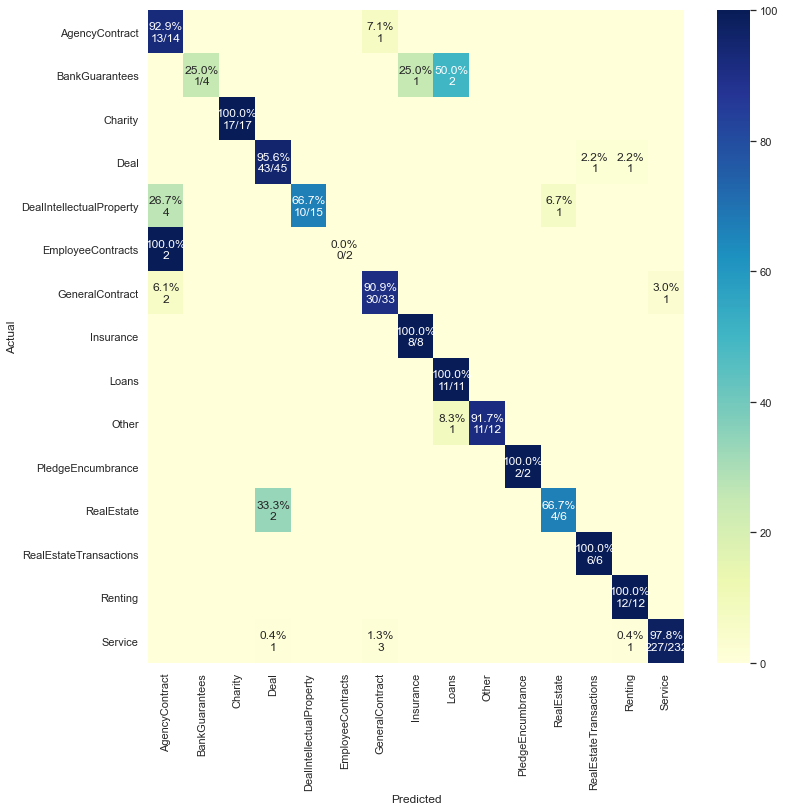

In [30]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


make_report(umodel, ev[~pd.isna(ev['predicted_subj'])])

# Evaluate tags detection

### Contract number validation

In [31]:
tags.fillna('-', inplace=True)
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
logger.info( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags)}%) were detected wronggly')
wrong_numbers[['p-number', 'number']].to_csv('wrong_numbers.csv')
wrong_numbers[['p-number', 'number']].tail(10)


INFO - 2020-06-30 18:46:37,992 - retrain_ipynb - Contract numbers: 86 of 419  (20.525059665871122%) were detected wronggly
INFO - 2020-06-30 18:46:37,992 - retrain_ipynb - Contract numbers: 86 of 419  (20.525059665871122%) were detected wronggly
I0630 18:46:37.992963 4748930496 <ipython-input-31-ecb3a56d0a44>:3] Contract numbers: 86 of 419  (20.525059665871122%) were detected wronggly


,p-number,number
5eea27b2c28b75807f3daee5,,РЗ-17-02.02/094/__________________
5edbadd7da3678279fbcaabf,САХ-16/09000/00070/Р.,САХ-16/09000/00070/Р
5edbc660da3678279fbcaeac,САХ-17/00000/00016/Р.,САХ-17/00000/00016/Р
5edbc668da3678279fbcaf6e,САХ-17/07000/00073/Р.,САХ-17/07000/00073/Р
5edbc65dda3678279fbcae56,САХ-17/09000/00010/Р.,САХ-17/09000/00010/Р
5edbc66bda3678279fbcafe6,-,САХ-17/09000/00019/Р
5edbc615da3678279fbcadc9,САХ-17/09000/00072/Р.,САХ-17/09000/00072/Р
5edbc616da3678279fbcadce,САХ-17/04000/00069/Р,№САХ-17/04000/00069/Р
5edbc665da3678279fbcaf1b,-,№САХ-17/10966/00053/Р
5edbc5afda3678279fbcad6e,ЭЮС-10701/17,№ЭЮС-10701/17


### Contract Org-1 validation

In [32]:
tags.fillna('-', inplace=True)
wrong_orgs1 = tags [ tags['org-1-name'] != tags['p-org-1-name']]
logger.info( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags)}%) were detected incorrectly')

wrong_numbers[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].to_csv('wrong_orgs1.csv')
wrong_orgs1[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].head(20)

INFO - 2020-06-30 18:46:38,029 - retrain_ipynb - Org-1 name: 35 of 419  (8.353221957040573%) were detected incorrectly
INFO - 2020-06-30 18:46:38,029 - retrain_ipynb - Org-1 name: 35 of 419  (8.353221957040573%) were detected incorrectly
I0630 18:46:38.029752 4748930496 <ipython-input-32-73e30de83334>:3] Org-1 name: 35 of 419  (8.353221957040573%) were detected incorrectly


,p-org-2-name,p-org-2-name,org-1-name,org-2-name
5edbadd1da3678279fbcaa61,пожарного общества,пожарного общества,Адмиралтейское отделение Санкт-Петербургского ...,Газпромнефть-Сахалин
5edbadd2da3678279fbcaa77,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть Научно-Технический Центр,Газпромнефть-Сахалин
5edbadd3da3678279fbcaa8f,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,СОГАЗ
5edbadd8da3678279fbcaaf8,Компания voestalpine Tubulars GmbH & Co KG,Компания voestalpine Tubulars GmbH & Co KG,voestalpine Tubulars GmbH & Co KG,Газпромнефть-Сахалин
5ee188952281f29204c522de,Джессика Тавейра,Джессика Тавейра,Tenaris Global Services S. A.,Газпромнефть-Сахалин
5ee191e12281f29204c52303,гражданин Бишенов Руслан Ауесович,гражданин Бишенов Руслан Ауесович,Бишенов Руслан Ауесович,Газпромнефть-МНПЗ
5ee191e12281f29204c52304,-,-,Анцупов А. Н.,Газпромнефть-МНПЗ
5ee191e12281f29204c52306,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-ОНПЗ
5edbc616da3678279fbcadce,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Федотова Наталья Александровна
5edbc65cda3678279fbcae48,-,-,Газпромнефть-Сахалин,СофтЛайн Трейд


In [33]:
tags.fillna('-', inplace=True)
wrong_orgs2 = tags [ tags['org-2-name'] != tags['p-org-2-name']]
logger.info( f'Org-2 name: {len(wrong_orgs2)} of {len(tags)}  ({100. * len(wrong_orgs2) / len(tags)}%) were detected incorrectly')
wrong_orgs2[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].head(10)


INFO - 2020-06-30 18:46:38,114 - retrain_ipynb - Org-2 name: 61 of 419  (14.558472553699284%) were detected incorrectly
INFO - 2020-06-30 18:46:38,114 - retrain_ipynb - Org-2 name: 61 of 419  (14.558472553699284%) were detected incorrectly
I0630 18:46:38.114645 4748930496 <ipython-input-33-d3310a2f18e4>:3] Org-2 name: 61 of 419  (14.558472553699284%) were detected incorrectly


,p-org-2-name,p-org-2-name,org-1-name,org-2-name
5ded4e284ddc27bcf92dd6ce,центр развития ребенка-детский сад № 135 города,центр развития ребенка-детский сад № 135 города,Газпромнефть-МНПЗ,центр развития ребенка - детский сад № 135 гор...
5edbadc1da3678279fbcaa21,Эрнст энд Янг-оценка,Эрнст энд Янг-оценка,Газпромнефть-Сахалин,Эрнст энд Янг – оценка и консультационные услуги
5edbadd1da3678279fbcaa61,пожарного общества,пожарного общества,Адмиралтейское отделение Санкт-Петербургского ...,Газпромнефть-Сахалин
5edbadd2da3678279fbcaa76,Московский государственный университет имени М. В,Московский государственный университет имени М. В,Газпромнефть-Сахалин,Московский государственный университет имени М...
5edbadd3da3678279fbcaa8f,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,СОГАЗ
5edbadd4da3678279fbcaa9f,Центр корпоративного обучения «ПрайсвотерхаусК...,Центр корпоративного обучения «ПрайсвотерхаусК...,Газпромнефть-Сахалин,Центр корпоративного обучения «ПрайсвотерхаусК...
5edbadd7da3678279fbcaabf,по сертификации «Русский Регистр»,по сертификации «Русский Регистр»,Газпромнефть-Сахалин,Русский Регистр
5edbadd8da3678279fbcaaf8,Компания voestalpine Tubulars GmbH & Co KG,Компания voestalpine Tubulars GmbH & Co KG,voestalpine Tubulars GmbH & Co KG,Газпромнефть-Сахалин
5ee188952281f29204c522de,Джессика Тавейра,Джессика Тавейра,Tenaris Global Services S. A.,Газпромнефть-Сахалин
5ee191e12281f29204c52303,гражданин Бишенов Руслан Ауесович,гражданин Бишенов Руслан Ауесович,Бишенов Руслан Ауесович,Газпромнефть-МНПЗ


In [36]:

wrong_aliases1 = tags [ tags['org-1-alias'] != tags['p-org-1-alias']]
logger.info( f'Alias-1: {len(wrong_aliases1)} of {len(tags)}  ({100. * len(wrong_aliases1) / len(tags)}%) were detected incorrectly')
# wrong_orgs[['p-org-1-alias', 'p-org-2-alias', 'org-1-alias', 'org-2-alias']].head(10)

wrong_aliases2 = tags [ tags['org-2-alias'] != tags['p-org-2-alias']]
logger.info( f'Alias-2: {len(wrong_aliases2)} of {len(tags)}  ({100. * len(wrong_aliases2) / len(tags)}%) were detected incorrectly')
wrong_aliases2[['p-org-1-alias', 'p-org-2-alias', 'org-1-alias', 'org-2-alias']].head(10)

INFO - 2020-06-30 18:47:19,936 - retrain_ipynb - Alias-1: 30 of 419  (7.159904534606206%) were detected incorrectly
INFO - 2020-06-30 18:47:19,936 - retrain_ipynb - Alias-1: 30 of 419  (7.159904534606206%) were detected incorrectly
I0630 18:47:19.936116 4748930496 <ipython-input-36-9e27cec1ce8a>:2] Alias-1: 30 of 419  (7.159904534606206%) were detected incorrectly
INFO - 2020-06-30 18:47:19,942 - retrain_ipynb - Alias-2: 41 of 419  (9.785202863961814%) were detected incorrectly
INFO - 2020-06-30 18:47:19,942 - retrain_ipynb - Alias-2: 41 of 419  (9.785202863961814%) were detected incorrectly
I0630 18:47:19.942788 4748930496 <ipython-input-36-9e27cec1ce8a>:6] Alias-2: 41 of 419  (9.785202863961814%) were detected incorrectly


,p-org-1-alias,p-org-2-alias,org-1-alias,org-2-alias
5e58df7823869ee435388239,-,Залогодатель,Залогодатель,Залогодержатель
5edbadc1da3678279fbcaa21,-,-,Заказчик,Исполнитель
5edbadd0da3678279fbcaa4f,-,-,Заказчик,Исполнитель
5edbadd5da3678279fbcaaa3,Заказчик,Обучающийся,Заказчик,Исполнитель
5edbadd7da3678279fbcaabc,Исполнитель,-,Заказчик,Исполнитель
5edbadd8da3678279fbcaaf8,-,Покупатель,Покупатель,Продавец
5edbc616da3678279fbcadce,-,Арендатор,Арендатор,Арендодатель
5edbc628da3678279fbcadee,Покупатель,-,Покупатель,Поставщик
5edbc637da3678279fbcae1a,-,-,Заказчик,Исполнитель
5edbc63ada3678279fbcae23,Покупатель,-,Покупатель,Поставщик


In [37]:
wrong_types1 = tags [ tags['org-1-type'] != tags['p-org-1-type']]
wrong_types2 = tags [ tags['org-2-type'] != tags['p-org-2-type']]

In [47]:
from collections import Counter

counter = Counter()
for i in wrong_orgs1.index:
  counter[i]+=1
for i in wrong_orgs2.index:
  counter[i]+=1
for i in wrong_numbers.index:
  counter[i]+=1
for i in wrong_aliases1.index:
  counter[i]+=1
for i in wrong_aliases2.index:
  counter[i]+=1
for i in errors_report.index:
  counter[i]+=1

print(counter.most_common()[0][0])

5edbc616da3678279fbcadce


In [39]:
umtm.stats['errors']=0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

I0630 18:47:20.164164 4748930496 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 609
I0630 18:47:20.321851 4748930496 retrain_contract_uber_model.py:283] docs in meta: 609
I0630 18:47:20.330487 4748930496 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 609
I0630 18:47:20.355371 4748930496 retrain_contract_uber_model.py:283] docs in meta: 609
I0630 18:47:20.362439 4748930496 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 609


,export_date,subject,org-1-alias,org-2-alias,checksum,version,analyze_date,value,value_log1p,value_span,subject confidence,user_correction_date,valid,subject_weight,sample_weight,error,errors
_id,,,,,,,,,,,,,,,,,
5eea279dc28b75807f3dacce,2020-06-26 21:19:39.652608,Loans,Заемщик,Займодавец,a2fd74d33e546dc0fde7ae1d50eb3cae,1.20.0,2020-06-18 20:26:19.609,6.040500e+10,24.824338,148.0,0.997801,2020-06-17 15:44:57.491,True,4.684771,4.175352,NaN,1
5eea27adc28b75807f3dae66,2020-06-26 21:20:05.776125,GeneralContract,Заказчик/ЗАКАЗЧИК,Подрядчик/ПОДРЯДЧИК/ЕРС-Подрядчик,8a9ce8cea53e54a03caa5c252ad2bb7b,1.20.0,2020-06-19 16:18:47.247,2.807709e+10,24.058220,21847.0,0.955438,2020-06-19 05:39:50.512,True,1.665285,0.742101,NaN,0
5eea279dc28b75807f3daccb,2020-06-26 21:19:39.455999,Loans,Займодавец,Заемщик,839bd7f3a1a443ffdf00c200788df8b3,1.20.0,2020-06-18 20:25:14.243,2.215000e+09,21.518518,159.0,0.973850,2020-06-17 15:45:57.928,True,4.060908,3.619326,NaN,1
5eea27b1c28b75807f3daec7,2020-06-26 21:20:14.792316,GeneralContract,Заказчик,Подрядчик,571145b01a3a2e2ac7f486d3f73a1b19,1.20.0,2020-06-19 18:46:02.512,1.789183e+09,21.305025,4826.0,0.388674,2020-06-19 10:23:11.225,True,1.474712,0.657176,NaN,0
5dfa6a938d25a1ac83160bf1,2020-06-26 21:17:55.126244,Service,Заказчик,Исполнитель,e10d3bc6db3c286eddbbbc9107850830,1.11.2,2020-06-12 21:20:30.568,1.770000e+09,21.294245,9482.0,0.984551,2020-06-06 11:44:17.759,True,1.708489,1.522709,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5edbc662da3678279fbcaee3,2020-06-26 21:18:35.961911,Service,Владелец Лицензии,Оператор,e4a73074aa926fad45a8d2d4eec06619,1.11.5,2020-06-16 11:23:18.643,NaN,NaN,NaN,0.999367,NaT,True,0.052638,0.023457,NaN,0
5edbc65fda3678279fbcae91,2020-06-26 21:18:30.856139,Service,Владелец Лицензии,Оператор,de8d0defd01d62a35e971d556f18037d,1.11.5,2020-06-16 11:19:38.025,NaN,NaN,NaN,0.998887,NaT,True,0.052638,0.023457,NaN,0
5edbc65dda3678279fbcae68,2020-06-26 21:18:28.936219,Service,Заказчик,,e6050d7bfaa96e7a8b283c36c4490687,1.11.5,2020-06-16 11:18:03.345,NaN,NaN,NaN,0.999537,NaT,True,0.052638,0.023457,NaN,0


## Single doc eval

In [49]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

I0630 18:48:57.217986 4748930496 <ipython-input-49-1b76c9271c48>:14] fetching 5edbc616da3678279fbcadce


SAMPLE_DOC_ID: 5edbc616da3678279fbcadce


In [50]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

2 uber_detection_model_005_1_1
Subject: (<ContractSubject.Renting: 9>, 0.9886360168457031, 9)


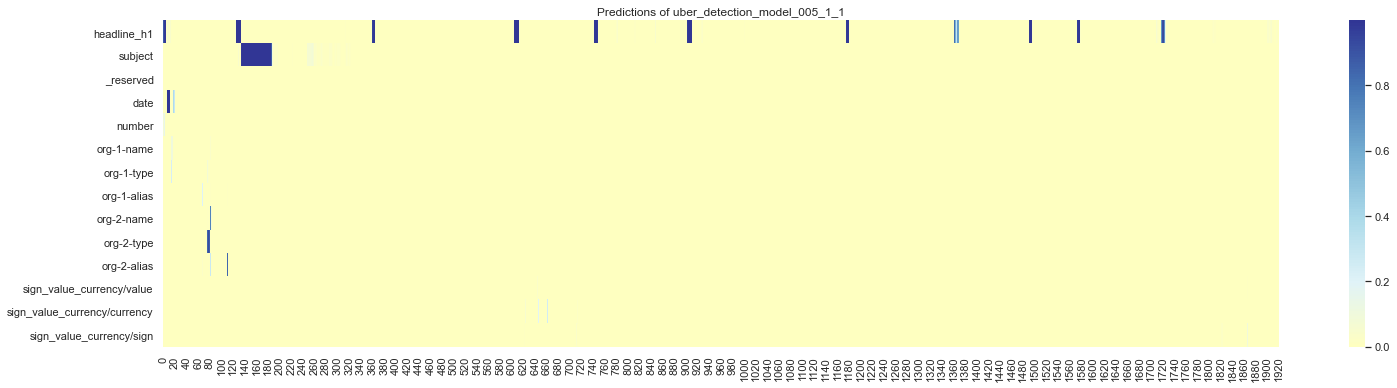

In [51]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  print(t.upper(), spans)
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:
mean_ = tagging.values.max(-1)*0.5
print (mean_.shape)
display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:14000],  mean_[:14000])))